In [56]:
import pandas as pd
import numpy as np

file_name='RM_MCs.csv'
df=pd.read_csv(file_name,parse_dates=True,index_col='date_of_service_dttm')

print(df.shape[0])
print('number of patients:',len(df.mrn.unique()))
print (df.head())

### strain out val dfs
df_val=pd.read_csv('UC_recurrent_mrns.csv')
try:
    df_val.MRN=df_val.MRN.str.replace('-','')
    df_val.MRN=df_val.MRN.astype('int64')
except:
    print('mrns are already in correct form')
    
mrns_val=df_val.MRN.unique()
    
df=df[~df['mrn'].isin(mrns_val)]
print('number of patients without val cohort:',len(df.mrn.unique()))

### strain out people that start with RM=1 and have super long notes
mrns=df.mrn.unique()
good_mrns=[]
for mrn in mrns:
    sub_df=df[df['mrn']==mrn]
    if sub_df.iloc[0]['is_RM'] != 1:
        good_mrns.append(mrn)
df=df[df['mrn'].isin(good_mrns)]
print('number of patients that start without disease:',len(df.mrn.unique()))

### strain out people that never convert
# df_with_RM=df[df['is_RM']==1]
# mrns_with_changes=df_with_RM.mrn.unique()
# df=df[df['mrn'].isin(mrns_with_changes)]
# print('number of patients that get RM disease:',len(df.mrn.unique()))



7397
number of patients: 171
                          mrn  is_RM
date_of_service_dttm                
1996-02-26            2050963      0
2009-01-23            2050963      0
2009-10-01            2050963      0
2010-02-19            2050963      0
2010-03-01            2050963      0
number of patients without val cohort: 151
number of patients that start without disease: 132


In [57]:
### create sub df by mrn
ptx_info=[]
for index,mrn in enumerate(df.mrn.unique()):
    sub_df=df[df['mrn']==mrn]
    ptx_info.append(sub_df)
print (len(ptx_info))
### re index to monthly

def to_monthly(df_input):
    df_working=df_input

    df_d=df_working.resample('D').mean()
    df_d['mrn']=df_d['mrn'].ffill()
    df_d['is_RM']=df_d['is_RM'].ffill()

    df_m=df_d.resample('M').mean()
    df_m.is_RM.value_counts()

    df_m['is_RM']=df_m['is_RM'].apply(lambda a:a>0).astype(int)
    return df_m
for index,ptx in enumerate(ptx_info):
    ptx_info[index]=to_monthly(ptx)
print (len(ptx_info))
print (ptx_info[0])

df_rebuilt=''
for index,ptx in enumerate(ptx_info):
    if index==0:
        df_rebuilt=ptx_info[0]
    else:
        df_rebuilt=df_rebuilt.append(ptx)

132
132
                            mrn  is_RM
date_of_service_dttm                  
1996-02-29            2050963.0      0
1996-03-31            2050963.0      0
1996-04-30            2050963.0      0
1996-05-31            2050963.0      0
1996-06-30            2050963.0      0
...                         ...    ...
2015-11-30            2050963.0      1
2015-12-31            2050963.0      1
2016-01-31            2050963.0      1
2016-02-29            2050963.0      1
2016-03-31            2050963.0      1

[242 rows x 2 columns]


In [58]:
def getTransitionMatrix(df):
    '''given a dataframe with mrn and states represented as last_RM, return a transition matrix'''
    transition_matrix_counts=[[0,0],[0,0]]
    transition_matrix_counts=np.array(transition_matrix_counts)
    
    mrns=df.mrn.unique()
    ptx_info=[]
    for mrn in mrns:
        df_sub=df[df['mrn']==mrn]
        ptx_info.append(df_sub)

    for ptx in ptx_info:
        # get transition matrix counts
        df_working=ptx
        df_working['last_RM']=df_working.is_RM.shift(1)
        for index,row in df_working.iterrows():
            last_RM=row['last_RM']
            RM=row['is_RM']

            if last_RM==0 and RM==0:
                transition_matrix_counts[0][0]+=1
            elif last_RM==0 and RM==1:
                transition_matrix_counts[0][1]+=1
            elif last_RM==1 and RM==0:
                transition_matrix_counts[1][0]+=1
            elif last_RM==1 and RM==1:
                transition_matrix_counts[1][1]+=1
    transition_matrix=transition_matrix_counts/transition_matrix_counts.sum(axis=1)[:,None]
    transition_matrix=np.nan_to_num(transition_matrix)
    return transition_matrix
    
transition_matrix=getTransitionMatrix(df_rebuilt)
print (transition_matrix)

C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[[0.9650716 0.0349284]
 [0.        1.       ]]


In [59]:
### produce transition matrices for every 12 month increment in the data (up to 5 years), then rest
import math

def divide_df(df):
    ''' divides a dataframe by row into a given number of splits'''
    dfs=[]
    df_working=df
    num_rows=df.shape[0]
    num_splits=0
    if num_rows/12<=5:
        num_splits=math.ceil(num_rows/12)
    else:
        num_splits=6
    while (num_splits>=1):
        if num_splits==1:
            df_append=df_working
        else:
            df_append=df_working.iloc[:12,:]
            df_working=df_working.iloc[12:,:]
        dfs.append(df_append)
        num_splits=num_splits-1
    while len(dfs)<6:
        empty=pd.DataFrame(columns=df.columns)
        dfs.append(empty)
    return dfs
    
df_1='';df_2='';df_3='';df_4='';df_5='';df_6='';
for index,ptx in enumerate(ptx_info):
    dfs=divide_df(ptx)
    if index==0:
        df_1=dfs[0]
        df_2=dfs[1]
        df_3=dfs[2]
        df_4=dfs[3]
        df_5=dfs[4]
        df_6=dfs[5]
    else:
        df_1=df_1.append(dfs[0])
        df_2=df_2.append(dfs[1])
        df_3=df_3.append(dfs[2])
        df_4=df_4.append(dfs[3])
        df_5=df_5.append(dfs[4])
        df_6=df_6.append(dfs[5])
TMs=[]
TMs.append(getTransitionMatrix(df_1))
TMs.append(getTransitionMatrix(df_2))
TMs.append(getTransitionMatrix(df_3))
TMs.append(getTransitionMatrix(df_4))
TMs.append(getTransitionMatrix(df_5))
TMs.append(getTransitionMatrix(df_6))
for index,TM in enumerate(TMs):
    print ('year',index+1,'\t',TM)

C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


year 1 	 [[0.93326382 0.06673618]
 [0.         1.        ]]
year 2 	 [[0.97986577 0.02013423]
 [0.         1.        ]]
year 3 	 [[0.98201439 0.01798561]
 [0.         1.        ]]
year 4 	 [[0.98611111 0.01388889]
 [0.         1.        ]]
year 5 	 [[0.97546012 0.02453988]
 [0.         1.        ]]
year 6 	 [[0.98338369 0.01661631]
 [0.         1.        ]]


In [60]:
class MarkovChain(object):
    def __init__(self,transition_matrix,states):
        self.transition_matrix=np.atleast_2d(transition_matrix)
        self.states=states
        self.index_dict={self.states[index]:index for index in range(len(self.states))}
        self.state_dict={index: self.states[index] for index in range(len(self.states))}
    def next_state(self,current_state):
        return np.random.choice(
        self.states,
        p=self.transition_matrix[self.index_dict[current_state], :]
        )
    def generate_states(self,current_state,no=10):
        future_states=[]
        for i in range(no):
            next_state=self.next_state(current_state)
            future_states.append(next_state)
            current_state=next_state
        return future_states
    
def produceMCSimulationData(n_chains):
    '''give input of number of chains for iteration, returns a df simulating MC for that population'''
    data=[]
    ### select number of chains to produce
    for i in range(n_chains):
        ### code to generate markov chains - iterates through the series of TMs for risk in years 1,2,3,4,5,6+
        for index,TM in enumerate(TMs):
            disease_chain=MarkovChain(transition_matrix=TM,states=[0,1])
            if index==0:
                l=disease_chain.generate_states(current_state=0,no=12)
                chain=l
            else:
                l=disease_chain.generate_states(current_state=chain[-1],no=12)
                chain=chain+l
        for month, state in enumerate(chain):
            data.append([i,month,state])
    df_MC=pd.DataFrame(data=data,columns=['ID','month','state'])
    return df_MC

### Kaplan Meier
### get T and E for each ID
def get_df_KM(df):
    df_MC=df.sort_values(by='month',ascending=True)
    ptx_info=[]
    for ID in df_MC.ID.unique():
        sub_df=df_MC[df_MC.ID==ID]
        ptx_info.append(sub_df)
    data_KM=[]
    for index,ptx in enumerate(ptx_info):
        df_working=ptx_info[index]

        T=0
        cont=True
        for index,row in df_working.iterrows():
            if cont:
                if row['state']==1:
                    T=row['month']
                    cont=False
        if cont==True:
            T=df_working.iloc[-1]['month']
        
        E=df_working.iloc[-1]['state']
        data_KM.append([df_working.iloc[0]['ID'],T,E])
    df_KM=pd.DataFrame(data=data_KM, columns=['ID','T','E'])
    return df_KM

#df_MC=produceMCSimulationData(50)
#print (df_MC)
#df_KM=get_df_KM(df_MC)
#print (df_KM)

### generate kaplan-meier
from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()
survival_cohort=''
for i in range(20):
    df_MC=produceMCSimulationData(20)
    df_KM=get_df_KM(df_MC)
    T=df_KM['T']
    E=df_KM['E']
    kmf.fit(T, E, label='model')
    l=[i for i in range(60)]
    s=kmf.predict(l)
    if i==0:
        survival_cohort=s
    else:
        survival_cohort=pd.concat([survival_cohort,s],axis=1)
        
survival_cohort['mean']=survival_cohort.mean(axis=1)
#survival_cohort['std']=survival_cohort.std(axis=1)
survival_cohort['RM_out_of_1000']=(1-survival_cohort['mean'])*1000
survival_cohort['affected']=survival_cohort['RM_out_of_1000'].diff()
survival_cohort['affected']=survival_cohort['affected'].fillna(survival_cohort.iloc[0]['RM_out_of_1000'])
print (survival_cohort)

### get T and E
data=[]
for index,row in survival_cohort.iterrows():
    month=index+1
    n=row['affected']
    for i in range(int(n)):
        data.append([month,1])
while len(data)<1000:
    data.append([60,0])
df_KM=pd.DataFrame(data=data, columns=['T','E'])
print (df_KM)

    model  model  model  model  model  model  model  model  model  model  ...  \
0    0.95   1.00   0.95   0.85   1.00   0.90   0.80   0.90   0.85   0.95  ...   
1    0.90   1.00   0.90   0.75   1.00   0.85   0.80   0.75   0.80   0.90  ...   
2    0.90   0.90   0.85   0.70   1.00   0.80   0.70   0.70   0.80   0.80  ...   
3    0.80   0.75   0.85   0.60   0.95   0.80   0.60   0.70   0.70   0.65  ...   
4    0.75   0.70   0.85   0.60   0.85   0.80   0.55   0.70   0.65   0.65  ...   
5    0.75   0.70   0.85   0.50   0.80   0.80   0.50   0.65   0.50   0.65  ...   
6    0.65   0.55   0.75   0.50   0.70   0.70   0.45   0.65   0.50   0.65  ...   
7    0.65   0.45   0.55   0.50   0.70   0.70   0.45   0.55   0.40   0.60  ...   
8    0.60   0.45   0.50   0.45   0.60   0.65   0.45   0.55   0.40   0.55  ...   
9    0.60   0.40   0.45   0.45   0.55   0.55   0.45   0.50   0.35   0.55  ...   
10   0.60   0.40   0.40   0.40   0.55   0.55   0.40   0.40   0.35   0.50  ...   
11   0.55   0.40   0.40   0.

In [61]:
# ### graph markov chains
# import matplotlib.pyplot as plt
# import seaborn as sns

# d={}
# counts=[]
# for ID in df_MC.ID.unique():
#     df_sub=df_MC[df_MC.ID==ID]
#     if df_sub.iloc[0]['state']==1:
#         d[ID]=-1
#     else:
#         start=df_sub.iloc[0].month
#         end=df_sub.iloc[-1].month
#         keep_going=True
#         for index,row in df_sub.iterrows():
#             if keep_going and row['state']==1:
#                 keep_going=False
#                 end=row['month']
#         d[ID]=end-start
# for index,row in df_MC.iterrows():
#     counts.append(d[row['ID']])
# df_MC['rank_order']=counts
# df_MC=df_MC.sort_values(by='rank_order',ascending=False)
# order=df_MC.ID.unique()

# # get only blue dots
# df_MC_graph=df_MC[df_MC.state==0]

# grid=sns.catplot(x='ID', y="month", hue="state", palette={0:'Blue'},jitter=False, 
#                  **{'alpha':.8,'s':1.75},data=df_MC_graph, height=5, aspect=3,order=order)
# grid.set(xticks=[])
# grid.set(xlabel='',title='Simulated Patient Trajectories,n='+str(n_chains))
# plt.savefig('MCMC.png')

In [62]:
### old version 20200723

# class MarkovChain(object):
#     def __init__(self,transition_matrix,states):
#         self.transition_matrix=np.atleast_2d(transition_matrix)
#         self.states=states
#         self.index_dict={self.states[index]:index for index in range(len(self.states))}
#         self.state_dict={index: self.states[index] for index in range(len(self.states))}
#     def next_state(self,current_state):
#         return np.random.choice(
#         self.states,
#         p=self.transition_matrix[self.index_dict[current_state], :]
#         )
#     def generate_states(self,current_state,no=10):
#         future_states=[]
#         for i in range(no):
#             next_state=self.next_state(current_state)
#             future_states.append(next_state)
#             current_state=next_state
#         return future_states
    
# disease_chain=MarkovChain(transition_matrix=transition_matrix,states=[0,1])
# data=[]

# ### select number of chains to produce
# n_chains=50

# for i in range(n_chains):
#     l=disease_chain.generate_states(current_state=0,no=60)
#     for month,state in enumerate(l):
#         data.append([i,month,state])
# df_MC=pd.DataFrame(data=data,columns=['ID','month','state'])
# print (df_MC)

# import matplotlib.pyplot as plt
# import seaborn as sns

# d={}
# counts=[]
# for ID in df_MC.ID.unique():
#     df_sub=df_MC[df_MC.ID==ID]
#     if df_sub.iloc[0]['state']==1:
#         d[ID]=-1
#     else:
#         start=df_sub.iloc[0].month
#         end=df_sub.iloc[-1].month
#         keep_going=True
#         for index,row in df_sub.iterrows():
#             if keep_going and row['state']==1:
#                 keep_going=False
#                 end=row['month']
#         d[ID]=end-start
# for index,row in df_MC.iterrows():
#     counts.append(d[row['ID']])
# df_MC['rank_order']=counts
# df_MC=df_MC.sort_values(by='rank_order',ascending=False)
# order=df_MC.ID.unique()

# # get only blue dots
# df_MC_graph=df_MC[df_MC.state==0]

# grid=sns.catplot(x='ID', y="month", hue="state", palette={0:'Blue'},jitter=False, 
#                  **{'alpha':.8,'s':1.75},data=df_MC_graph, height=5, aspect=3,order=order)
# grid.set(xticks=[])
# grid.set(xlabel='',title='Simulated Patient Trajectories,n='+str(n_chains))
# plt.savefig('MCMC.png')

In [63]:
### prepare validation set
df_val=pd.read_csv('UC_recurrent_mrns.csv')
print ('starting number of validated patients:',df_val.shape[0])
cols=['MRN','Last Treatment Date','Date of Progression','Date of Death']
df_val=df_val[cols]
### convert Last Treatment Date, Date of Progression, and Date of Death to datetime
df_val['Last Treatment Date']=pd.to_datetime(df_val['Last Treatment Date'],infer_datetime_format=True, errors='coerce')
df_val['Date of Progression']=pd.to_datetime(df_val['Date of Progression'],infer_datetime_format=True, errors='coerce')
df_val['Date of Death']=pd.to_datetime(df_val['Date of Death'],infer_datetime_format=True,errors='coerce')
### convert MRNs to int
try:
    df_val.MRN=df_val.MRN.str.replace('-','')
    df_val.MRN=df_val.MRN.astype('int64')
except:
    print('mrns are already in correct form')
### filter out patients that have no data
#df_mrns=pd.read_csv('RM_MCs.csv')
#mrns=df_mrns.mrn.unique()
#df_val=df_val[df_val['MRN'].isin(mrns)]
#print ('number of validated patients with timelines:',df_val.shape[0])
### take patients one at a time and make a dataframe with: mrn, date, state
data=[]
for mrn in df_val.MRN.unique():
    ### start with earliest state, set as 0
    df_sub=df_val[df_val['MRN']==mrn]
    earliest=df_sub.iloc[0]['Last Treatment Date']
    first_datum=[mrn,earliest,0]
    data.append(first_datum)
    ### get the date of recurrence
    df_sub=df_val[df_val['MRN']==mrn]
    date_RM=df_sub.iloc[0]['Date of Progression']
    flags=df_sub['Date of Progression'].isna()
    isna_prog=flags.iloc[0]
    if not isna_prog:
        sec_datum=[mrn,date_RM,1]
        data.append(sec_datum)
    ### add date of death
    date_death=df_sub.iloc[0]['Date of Death']
    flags=df_sub['Date of Death'].isna()
    isna_death=flags.iloc[0]
    if not isna_death and isna_prog:
        third_datum=[mrn,date_death,np.nan]
        data.append(third_datum)
df_val_MCs=pd.DataFrame(data=data,columns=['mrn','Date','is_RM'])
df_val_MCs['is_RM']=df_val_MCs['is_RM'].ffill()
df_val_MCs=df_val_MCs.set_index('Date', drop=True)
print (df_val_MCs)
### change to monthly
# get sub_dfs
ptx_info=[]
for mrn in df_val_MCs['mrn'].unique():
    sub_df=df_val_MCs[df_val_MCs['mrn']==mrn]
    ptx_info.append(sub_df)
#print (len(ptx_info))

for index,ptx in enumerate(ptx_info):
    ptx_info[index]=to_monthly(ptx)
    ptx_info[index]=ptx_info[index].reset_index()
    ptx_info[index]['month']=ptx_info[index].index

print (ptx_info[2])

data=[]
for index,ptx in enumerate(ptx_info):
    T=ptx_info[index].iloc[-1]['month']
    E=ptx_info[index].iloc[-1]['is_RM']
    data.append([T,E])
df_MC_val=pd.DataFrame(data=data, columns=['T','E'])
print (df_MC_val)


starting number of validated patients: 43
                mrn  is_RM
Date                      
2014-06-06  3375948    0.0
2014-08-22  3375948    1.0
2014-05-13  3361810    0.0
2014-07-15  3361810    1.0
2012-09-08  3261049    0.0
...             ...    ...
2010-04-15  2876217    1.0
2016-05-13  3513634    0.0
2018-07-25  3513634    1.0
2017-12-17  3713835    0.0
2018-05-23  3713835    1.0

[86 rows x 2 columns]
        Date        mrn  is_RM  month
0 2012-09-30  3261049.0      0      0
1 2012-10-31  3261049.0      0      1
2 2012-11-30  3261049.0      1      2
     T  E
0    2  1
1    2  1
2    2  1
3   16  1
4    1  1
5   11  1
6    4  1
7    9  1
8   21  1
9    2  1
10   2  1
11   5  1
12  81  1
13   7  1
14  37  1
15  62  1
16   1  1
17   3  1
18   1  1
19   2  1
20   5  1
21   6  1
22   5  1
23   6  1
24   1  1
25  38  1
26  38  1
27   7  1
28  20  0
29  46  1
30  37  1
31  39  1
32  33  1
33   2  1
34  24  1
35  11  1
36  12  1
37   6  1
38   8  1
39  14  1
40   0  1
41  26  1
42

model: median time to RM: 10.0 months
12    0.413
24    0.319
36    0.271
48    0.240
60    0.182
Name: model, dtype: float64
validation: median time to RM: 7.0 months
12    0.348837
24    0.251938
36    0.201550
48    0.050388
60    0.050388
Name: validation, dtype: float64


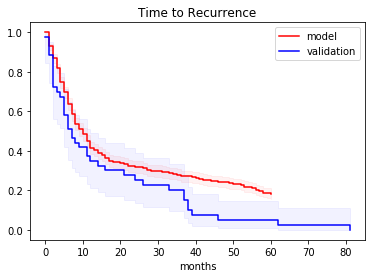

In [64]:
### Kaplan Meier
### get T and E for each ID
# df_MC=df_MC.sort_values(by='month')
# ptx_info=[]
# for ID in df_MC.ID.unique():
#     sub_df=df_MC[df_MC.ID==ID]
#     ptx_info.append(sub_df)
# print (len(ptx_info))

# data_KM=[]
# for index,ptx in enumerate(ptx_info):
#     df_working=ptx_info[index]
#     T=df_working.iloc[0]['rank_order']+1
#     E=df_working.iloc[-1]['state']
#     data_KM.append([df_working.iloc[0]['ID'],T,E])
# df_KM=pd.DataFrame(data=data_KM, columns=['ID','T','E'])
#print (df_KM.head())

### generate kaplan-meier
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
kmf=KaplanMeierFitter()
T=df_KM['T']
E=df_KM['E']
T_val=df_MC_val['T']
E_val=df_MC_val['E']

kmf.fit(T, E, label='model')
ax = kmf.plot(ci_show=True,ci_alpha=0.05,color='Red')
print('model: median time to RM:',kmf.median_survival_time_,'months')
print(kmf.predict([12,24,36,48,60]))

kmf.fit(T_val, E_val, label='validation')
ax = kmf.plot(ax=ax,ci_show=True,ci_alpha=0.05,color='Blue')
plt.title('Time to Recurrence')
plt.xlabel('months')
plt.savefig('MCMC_KM.png')

# kmf.fit(T, E)
# kmf.plot_survival_function() 
# plt.savefig('MCMC_KM.png')

print('validation: median time to RM:',kmf.median_survival_time_,'months')
#print('CI:',kmf.confidence_interval_)
#print(kmf.event_table)
print(kmf.predict([12,24,36,48,60]))

#log rank
from lifelines.statistics import logrank_test
results = logrank_test(T, T_val, event_observed_A=E, event_observed_B=E_val)
results.print_summary()